In [3]:
#SEGUNDA PARTE DE RDPG WFV
#RDPG AGENT 
#!pip install tensorflow==1.15.2 

     |████████████████████████████████| 110.5 MB 33 kB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
     |████████████████████████████████| 503 kB 41.4 MB/s 
     |████████████████████████████████| 3.8 MB 39.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7553 sha256=7b5ec096ba45c864445547fbe73577aa116f95dd92e70aecbf5ba4b2ec950a98
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [1]:
#RDPG AGENT
# -*- coding: utf-8 -*-



"""
Created on Sat May 30 20:52:21 2020
@author: ChefLiutao
The agent of RL algorithm Recurrent Detrministic Policy Gradient.
The Actor NNs are deployed as three-layer Fully-Connected NN.
The Critic NNs are deployed as RNN.
"""

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
tf.reset_default_graph()
import tensorflow as tf2 #Tensorflow 1.15.2
from tensorflow.contrib.rnn import LSTMCell
  



import numpy as np
from collections import deque
import random

class RDPG():
    def __init__(self,
                 n_features,
#                 n_actions,
                 a_low,
                 a_high,
                 learning_rate_actor,
                 learning_rate_critic,
                 n_actor_hidden,
                 n_critic_hidden,
                 gamma = 0.9,
                 noise_varience = 3,
                 soft_replace = 0.1,
                 memory_size = 1000,
                 batch_size = 128):
        self.n_features = n_features             #dimension of states
#        self.n_actions = n_actions        
        self.a_low = a_low                       #The low bound of action sapce
        self.a_high = a_high                     #The high bound of action space
        self.lr_a = learning_rate_actor          #Learning rate of Actor NN
        self.lr_c = learning_rate_critic         #Learning rate of Critic NN
        self.n_actor_hidden = n_actor_hidden     #Number of hidden layer neurons in Actor
        self.n_critic_cells = n_critic_hidden   #Number of hidden layer neurons in Critic
        self.gamma = gamma                       #Reward discount rate
        self.noise_var = noise_varience          #Variance of output action distribution
        self.soft_replace = soft_replace         #Update speed of target networks
        self.memory_size = memory_size           #Size of experience replay buffer
        self.memory = deque(maxlen = self.memory_size)   #Experience replay buffer
        self.batch_size = batch_size                     
        
        self.s = tf.placeholder(dtype = tf.float32,shape = [None,self.n_features])
        self.s_ = tf.placeholder(dtype = tf.float32,shape = [None,self.n_features])
        self.r = tf.placeholder(dtype = tf.float32,shape = [None,])
        self.done = tf.placeholder(dtype = tf.float32,shape = [None,]) # 0 if s_ == terminal else 1
        
        self.a = self.build_Actor1()
        self.a_ = self.build_Actor2()
        self.q_sa = self.build_Critic1()      #shape:[None,] 
        self.q_s_a_ = self.build_Critic2()    #shape:[None,]
        
        self.curr_a_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                            scope = 'Actor/Current')
        self.targ_a_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                            scope = 'Actor/Target')
        self.curr_c_params= tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                            scope = 'Critic/Current')
        self.targ_c_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                            scope = 'Critic/Target')
        
        # Soft replace of Targets NN parameters
        self.replace_a_params = [tf.assign(t,(1-self.soft_replace)*t + self.soft_replace*e) \
                                 for (t,e) in zip(self.targ_a_params,self.curr_a_params)]
        self.replace_c_params = [tf.assign(t,(1-self.soft_replace)*t + self.soft_replace*e) \
                                 for (t,e) in zip(self.targ_c_params,self.curr_c_params)]
        
        self.td_error = self.r + self.gamma*self.q_s_a_ - self.q_sa
        self.critic_loss = tf.reduce_mean(tf.square(self.td_error))
        self.actor_loss = -tf.reduce_mean(self.q_sa)
        
        self.actor_train_op = tf.train.AdamOptimizer(self.lr_a).minimize(self.actor_loss,
                                                    var_list = self.curr_a_params)
        self.critic_train_op = tf.train.AdamOptimizer(self.lr_c).minimize(self.critic_loss,
                                                     var_list = self.curr_c_params)
        
        self.learn_step_counter = 0
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    
    def build_Actor1(self):
        '''
        Building Current Actor network.
        '''
        with tf.variable_scope('Actor/Current'):
            w_init = tf.random_normal_initializer(0,0.1)
            b_init = tf.constant_initializer(0.1)
            w1 = tf.get_variable(name = 'w1',shape = [self.n_features,self.n_actor_hidden],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = True)
            b1 = tf.get_variable('b1',shape = [self.n_actor_hidden,],
                                 dtype = tf.float32,initializer = b_init,
                                 trainable = True)
            w2 = tf.get_variable('w2',shape = [self.n_actor_hidden,1],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = True)
            b2 = tf.get_variable('b2',shape = [1,],
                                 dtype = tf.float32,initializer = b_init,
                                 trainable = True)
            hidden = tf.nn.relu(tf.matmul(self.s,w1) + b1)
            a = tf.matmul(hidden,w2) + b2
        return a[:,0]
#            return np.clip(np.random.normal(a,self.noise_var),self.a_low,self.a_high)
    
    def build_Actor2(self):
        '''
        Building Target Actor network.
        '''
        with tf.variable_scope('Actor/Target'):
            w_init = tf.random_normal_initializer(0,0.1)
            b_init = tf.constant_initializer(0.1)
            w1 = tf.get_variable('w1',shape = [self.n_features,self.n_actor_hidden],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = False)
            b1 = tf.get_variable('b1',shape = [self.n_actor_hidden,],
                                 dtype = tf.float32,initializer = b_init,
                                 trainable = False)
            w2 = tf.get_variable('w2',shape = [self.n_actor_hidden,1],
                                 dtype = tf.float32,initializer = w_init,
                                 trainable = False)
            b2 = tf.get_variable('b2',shape = [1,],
                                 dtype = tf.float32,initializer = b_init,
                                 trainable = False)
            hidden = tf.nn.relu(tf.matmul(self.s_,w1) + b1)
            a_ = tf.matmul(hidden,w2) + b2
        return a_[:,0]
    
    def build_Critic1(self):
        '''
        Building Current Critic network.
        '''
        with tf.variable_scope('Critic/Current'):
            w_init = tf.random_normal_initializer(0,0.1)
            b_init = tf.constant_initializer(0.1)
            
            rnn_cell = tf2.contrib.rnn.BasicRNNCell(self.n_critic_cells)
            self.init_state = rnn_cell.zero_state(batch_size=1, dtype=tf.float64)
            s = tf.cast(tf.expand_dims(self.s,axis = 1),tf.float64)
            
            outputs, self.final_state = tf.nn.dynamic_rnn(
                    cell = rnn_cell, inputs = s, 
                    initial_state = self.init_state, time_major = True)
            cell_out = tf.cast(tf.reshape(outputs, [-1, self.n_critic_cells]),tf.float32)
            
            a_out = tf.layers.dense(self.a[:,np.newaxis],self.n_critic_cells,trainable = True)
            q_sa = tf.layers.dense(cell_out + a_out,1,tf.nn.relu,
                                   kernel_initializer = w_init,
                                   bias_initializer = b_init,trainable = True)

        return q_sa[:,0]
            
    
    def build_Critic2(self):
        '''
        Building Target Critic network.
        '''
        with tf.variable_scope('Critic/Target'):
            w_init = tf.random_normal_initializer(0,0.1)
            b_init = tf.constant_initializer(0.1)
            
            rnn_cell = tf2.contrib.rnn.BasicRNNCell(self.n_critic_cells)
            self.init_state = rnn_cell.zero_state(batch_size=1, dtype=tf.float64)
            s_ = tf.cast(tf.expand_dims(self.s_,axis = 1),tf.float64)
            
            outputs, self.final_state = tf.nn.dynamic_rnn(
                    cell = rnn_cell, inputs = s_, 
                    initial_state = self.init_state, time_major = True)
            cell_out = tf.cast(tf.reshape(outputs, [-1, self.n_critic_cells]),tf.float32)
            
            a_out = tf.layers.dense(self.a_[:,np.newaxis],self.n_critic_cells,trainable = False)
            q_s_a_ = tf.layers.dense(cell_out + a_out,1,tf.nn.relu,
                                   kernel_initializer = w_init,
                                   bias_initializer = b_init,trainable = False)

        return q_s_a_[:,0]         
    
    def choose_action(self,state):
        state = np.reshape(state,[-1,self.n_features])
        action = self.sess.run(self.a,feed_dict = {self.s:state})
        return action
    
    def store_transition(self,state,action,reward,next_state):
        state,next_state = state[np.newaxis,:],next_state[np.newaxis,:]
        action,reward = np.array(action),np.array(reward)
        action = np.reshape(action,[1,-1])
        reward = np.reshape(reward,[1,-1])
#        is_done = np.reshape(is_done,[1,-1])
        
        transition = np.concatenate((state,action,reward,next_state),axis = 1)
        self.memory.append(transition[0,:])
    
    def learn(self):
        if len(self.memory) == self.memory_size:
            if self.learn_step_counter % 200 == 0:
                self.sess.run((self.replace_a_params,self.replace_c_params))
            
            self.noise_var *= 0.999
                
            batch = np.array(random.sample(self.memory,self.batch_size))
            batch_s = batch[:,:self.n_features]
            batch_a = batch[:,self.n_features:(self.n_features + 1)][:,0]
            batch_r = batch[:,(self.n_features + 1):(self.n_features + 2)][:,0]
            batch_s_ = batch[:,(self.n_features + 2):(self.n_features*2 + 2)]
            
            self.sess.run(self.actor_train_op,feed_dict = {self.s:batch_s})
            self.sess.run(self.critic_train_op,feed_dict = {self.s:batch_s,
                                                            self.a:batch_a,
                                                            self.s_:batch_s_,
                                                            self.r:batch_r})

if __name__ == '__main__':
    rdpg = RDPG(5,0,1,0.03,0.01,30,30)

Instructions for updating:
non-resource variables are not supported in the long term
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [2]:
#data processing
# -*- coding: utf-8 -*-
"""
Created on Mon May 25 11:00:32 2020
@author: ChefLiutao
This part of code is to load and preprocess time series data.
"""

import numpy as np


def build_s_a(sequence,n,m):
    '''
    Args:
        sequence: Time series data
        n: The number of historical data denoting the current state
        m: The number of prediction steps in advance
    Return:
        state_mat: A matrix contains all states at each time step
        best_action: The optimal action based on each state
    '''
    n_rows = len(sequence)-n-m+1
    state_mat = np.zeros((n_rows,n))
    best_action = np.zeros(n_rows)
    for i in range(n_rows):
        state_mat[i] = sequence[i:(i+n)]
        best_action[i] = sequence[i+n+m-1]
    return state_mat,best_action



def normalization(traindata,testdata):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(traindata)
    traindata_scaled = scaler.transform(traindata)
    testdata_scaled = scaler.transform(testdata)
    
    return traindata_scaled,testdata_scaled

Episode 0 : -805.31
Episode 1 : -622.85


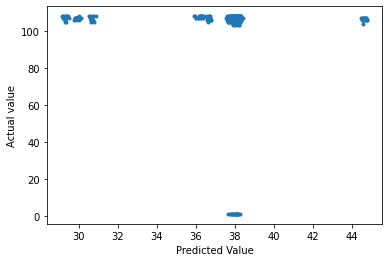

In [ ]:
#main
tf.reset_default_graph()
# -*- coding: utf-8 -*-
"""
Created on Fri May 29 23:23:52 2020
@author: ChefLiutao
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


#####################  hyper parameters  ####################
N_FEATURES = 6
A_LOW = 0
A_HIGH = 1
LR_A = 0.001
LR_C = 0.003
N_ACTOR_HIDDEN = 30
N_CRITIC_HIDDEN = 30
MAX_EPISODES = 2  #100  #5 RMSE=19  #2 RMSE=28  #3 RMSE=9.6  #21 ???
MAX_STEPS = 1000

GAMMA = 0.9                # 折扣因子
TAU = 0.1                 # 软更新因子
MEMORY_CAPACITY = 100000    #记忆库大小
BATCH_SIZE = 128            #批梯度下降的m
#############################################################

#Load data 
data = pd.read_csv('data.csv',encoding = 'gbk') #Carga de datasets *********************************************
cantidad=len(data)
data = data.iloc[:,0]  ##hasta el 65%, luego sacar 55 de training y 10 de test

#Build state matrix and best action
state,action = build_s_a(data,N_FEATURES,1)  

#Data split
SPLIT_RATE = 0.87   #WFV 87% PARA ENTRENAMIENTO para que sea 0-65% training y 65-75% test
split_index = round(len(state)*SPLIT_RATE)
train_s,train_a = state[:split_index],action[:split_index]
test_s,test_a = state[split_index:],action[split_index:]  


#Normalization
train_s_scaled,test_s_scaled = normalization(train_s,test_s)
A,B = train_a.max(),train_a.min()
train_a_scaled,test_a_scaled = (train_a-B)/(A-B),(test_a-B)/(A-B)

# Training
rdpg = RDPG(N_FEATURES,A_LOW,A_HIGH,LR_A,LR_C,N_ACTOR_HIDDEN,N_CRITIC_HIDDEN)
for episode  in range(MAX_EPISODES):
    index = np.random.choice(range(len(train_s_scaled)))
    s = train_s_scaled[index]
    ep_reward = 0
    
    for step in range(MAX_STEPS):
        a = rdpg.choose_action(s)
        r = -abs(a-train_a_scaled[index])
        ep_reward += r
        index += 1
        s_ = train_s_scaled[index]
        
        rdpg.store_transition(s,a,r,s_)
        rdpg.learn()
        
        if (index == len(train_s_scaled)-1) or (step == MAX_STEPS-1):
            print('Episode %d : %.2f'%(episode,ep_reward))
            break
        
        s = s_

# Testing
pred = []
for i in range(len(test_s_scaled)):
    state = test_s_scaled[i]
    action = rdpg.choose_action(state)
    pred.append(action)

pred = [pred[i][0] for i in range(len(test_s_scaled))]
pred = pd.Series(pred)
pred = pred*(A-B)+B
actual = pd.Series(test_a)

plt.scatter(pred,test_a,marker = '.')
plt.xlabel('Predicted Value')
plt.ylabel('Actual value')
plt.show()

In [ ]:
data

0         1
1       100
2       101
3       102
4       103
       ... 
6035    106
6036    106
6037    107
6038    106
6039    106
Name: 101, Length: 6040, dtype: int64

In [ ]:
len(test_a)

784

In [ ]:
#Convertir a dataframe las predicciones y el entrenamiento base
predictions1=pred.to_frame()
train_a=pd.DataFrame(train_a);

In [ ]:
train_a

,0
0,101.0
1,104.0
2,103.0
3,96.0
4,102.0
...,...
5245,107.0
5246,107.0
5247,108.0
5248,107.0


In [ ]:
predictions1

,0
0,-1686.359447
1,-1686.399065
2,-1686.420323
3,-1686.428225
4,-1686.416601
...,...
779,-1686.420323
780,-1686.411385
781,-1686.339514
782,-1686.396641


In [ ]:
#SEGUNDO ENTRENAMIENTO
#SE UNEN train1 y predictions1
train2 = pd.concat([train_a,predictions1])
len(train2)

6034

In [ ]:
cantidad2=len(train2)

In [ ]:
#se une train2 con el dataset original
#Load data 
data = pd.read_csv('raw_data_run1--1 - copia.csv',encoding = 'gbk') #Carga de datasets *********************************************
cantidad=len(data)
entrenamiento=int((cantidad/100)*65)
entrenamiento2=int((cantidad/100)*75)
data = data.iloc[entrenamiento2:cantidad,0]  
training2 = pd.concat([train2,data])

In [ ]:
len(training2)

8050

In [ ]:
data=training2
data=data.iloc[:,0].astype(int)

In [ ]:
data

0       101
1       104
2       103
3        96
4       102
       ... 
8058    103
8059    104
8060    101
8061    102
8062    101
Name: 0, Length: 8050, dtype: int64

In [ ]:
#exportar la data de 0-100 para entrenar con 0-75 y testear 75-100 prediciendo 75-100 

In [ ]:
data.to_csv('data1.csv')